## (Draft!) Train experiments with an autoencoder as DR

In [1]:
%load_ext autoreload
%autoreload 2

## Initialization

Imports

In [2]:
import sys
sys.path.append('../')

import torch
from torch import nn
import matplotlib.pyplot as plt

# local imports
from setup import setup_device, setup_datamodule, load_model
from adapters.main import capture_conv_layers
from dimensionality_reduction.feature_autoencoder import FeatureAutoencoder



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not in

Set the device globally

In [3]:
device = setup_device('cuda:2')
print(device, type(device))

cuda:2 <class 'torch.device'>


Load a trained model

In [4]:
model = load_model('../pre-trained/trained_UNets/mnmv2-00-02_22-11-2024-v1.ckpt', device)

Loaded as Lightning module


Initialize mnmv2 dataset module

In [5]:
datamodule = setup_datamodule()

In [6]:
for idx, data_batch in enumerate(iter(datamodule.val_dataloader())):
    print(idx, data_batch['input'].size(), data_batch['target'].size())
    # size format: [batch size, channels, width, hegiht]
    # next sample: data_sample = next(iter(datamodule.val_dataloader()))['input']

0 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
1 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
2 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
3 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
4 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
5 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
6 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
7 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
8 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
9 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
10 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
11 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
12 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
13 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
14 torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
15 torch.Size([25, 1, 256, 256]) torch.Size([25, 1, 256, 256])


Take the first batch from the datamodule

In [7]:
data_batch = next(iter(datamodule.val_dataloader()))

data_sample = data_batch['input']
data_sample.size() # [batch size, channels, width, hegiht]

torch.Size([32, 1, 256, 256])

Use hooks to capture hidden layer activations in the batch

In [8]:
wrapper, layer_names = capture_conv_layers(model, device, data_sample)

## Experiments

In [9]:
# no. of epochs for training
EPOCHS_COUNT = 100

# output dims of dim reduction
OUT_DIMS = 3

# display results for a selected sample
SAMPLE_ID = 10

Let's take some layer

In [10]:
# LAYER_ID = 10
LAYER_ID = 110

In [11]:
layer_samples = wrapper.layer_activations[layer_names[LAYER_ID]]

print(f"shape of the selected layer ([COUNT, C, H, W]): {layer_samples.size()}")

shape of the selected layer ([COUNT, C, H, W]): torch.Size([32, 16, 128, 128])


Define a train function

In [12]:
def train_batch(autoencoder, num_epochs: int, samples):
    epoch_loss = .0
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        for image in samples:
            latent, reconstructed = autoencoder(image)
            loss = criterion(reconstructed, image)
            optimizer.zero_grad() # reset gradients

            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(samples):.4f}")

    return autoencoder


Define visualization functions:

In [13]:
def visualize(image):
    if image.shape[0] > 3:  # If more than 3 channels, average channels
        # return image.mean(axis=0)
        return image[0]
    else:  # If 3 or fewer channels, just transpose to match image format
        return image.transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]

In [14]:
def plot_results(orig, reconstr, latent):
    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(visualize(orig), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Reconstructed Image
    axes[1].imshow(visualize(reconstr), cmap='gray')
    axes[1].set_title("Reconstructed Image")
    axes[1].axis("off")

    # Latent Representation (3 channels, like RGB)
    axes[2].imshow(latent.transpose(1, 2, 0))  # Transpose for [H, W, C]
    axes[2].set_title("Latent Representation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

torch.Size([1, 256, 256])


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

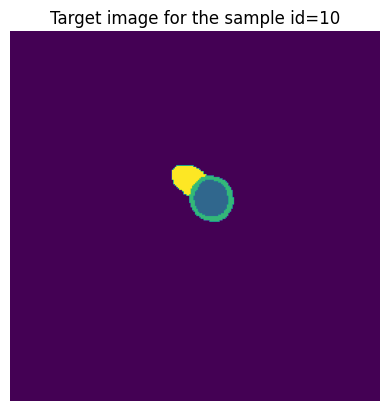

In [15]:
data_sample_target = data_batch['target'][SAMPLE_ID]
print(data_sample_target.size())

plt.imshow(data_sample_target.detach().numpy().transpose(1, 2, 0))
plt.title(f'Target image for the sample id={SAMPLE_ID}')
plt.axis("off")

### Single Layer Training

Create an instance of Autoencoder for training

In [16]:
BATCH_COUNT, C, H, W = layer_samples.detach().numpy().shape

autoencoder_single = FeatureAutoencoder(C, OUT_DIMS)

defined an autoencoder with input channels=16 and out channels=3


In [17]:
autoencoder_single = train_batch(autoencoder_single, EPOCHS_COUNT, [layer_samples[SAMPLE_ID]])

Epoch [100/100], Loss: 14.9359


Show the results

In [18]:
selected_sample = layer_samples[SAMPLE_ID]
latent_single, reconstructed_single = autoencoder_single(selected_sample)

In [19]:
original_single_np = selected_sample.detach().numpy()
latent_single_np = latent_single.detach().numpy()
reconstructed_single_np = reconstructed_single.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.0753517..1.1031631].


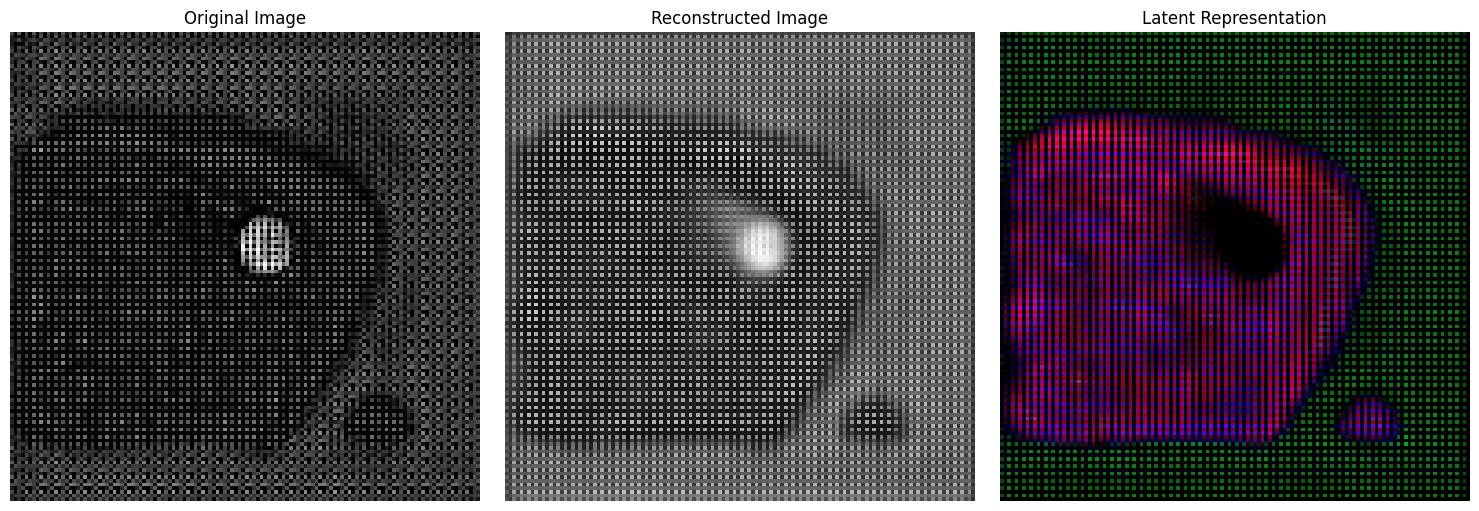

In [20]:
plot_results(original_single_np, reconstructed_single_np, latent_single_np)

### Single Batch Training

In [21]:
BATCH_COUNT, C, H, W = layer_samples.detach().numpy().shape

autoencoder_batch = FeatureAutoencoder(C, OUT_DIMS)

defined an autoencoder with input channels=16 and out channels=3


In [22]:
autoencoder_batch = train_batch(autoencoder_batch, EPOCHS_COUNT, layer_samples)

Epoch [100/100], Loss: 1.9864


Show the results

In [23]:
selected_sample = layer_samples[SAMPLE_ID]
latent_batch, reconstructed_batch = autoencoder_batch(selected_sample)

In [24]:
original_batch_np = selected_sample.detach().numpy()
latent_batch_np = latent_batch.detach().numpy()
reconstructed_batch_np = reconstructed_batch.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.245758..5.8002753].


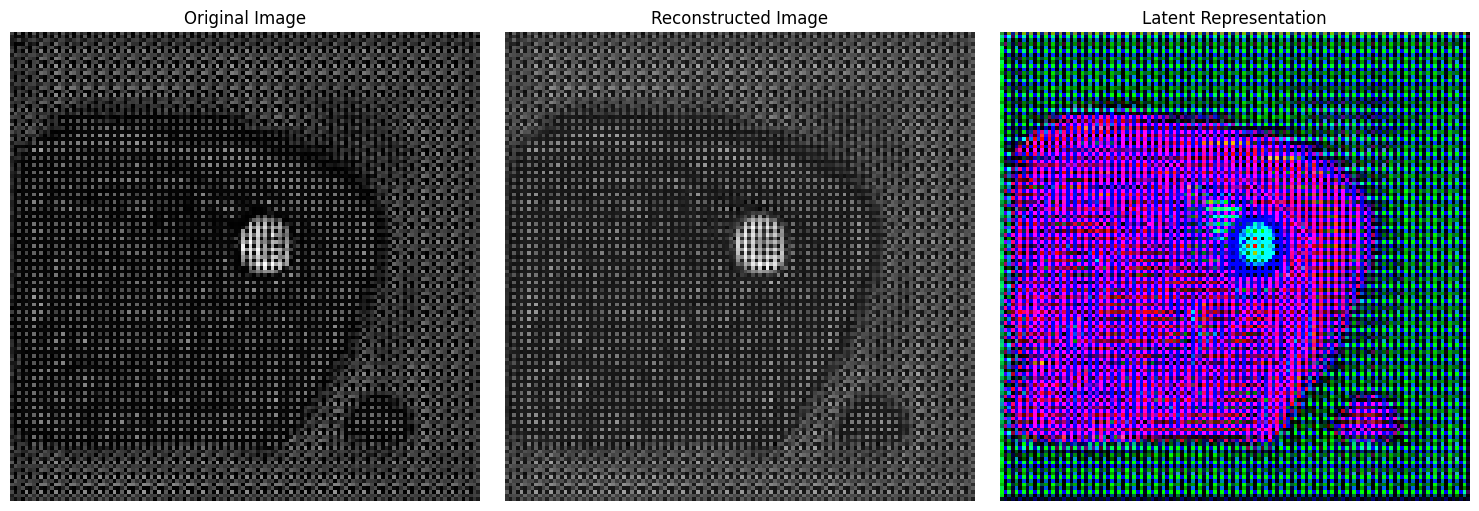

In [25]:
plot_results(original_batch_np, reconstructed_batch_np, latent_batch_np)

#### Conclusions
An autoencoder trained on a batch instead of a single image provides a more accurate representation (the borders are more properly defined and correspond to the target) of the layer and also a better reconstruction with a smaller loss.

=> let's try to perform training on a whole dataset and compare the results there as well.

### Whole Dataset Training

In [26]:
def train(autoencoder, num_epochs: int):
    epoch_loss = .0
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        for idx, data_batch in enumerate(iter(datamodule.val_dataloader())):
            inputs = data_batch['input']
            wrapper, layer_names = capture_conv_layers(model, device, inputs)
            layer_samples = wrapper.layer_activations[layer_names[LAYER_ID]]
            for image in layer_samples:
                # Forward pass
                latent, reconstructed = autoencoder(image)
                loss = criterion(reconstructed, image)
                optimizer.zero_grad()

                # Compute Loss
                epoch_loss += loss.item()

                # Backprop
                loss.backward()
                optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(layer_samples):.4f}")
    
    return autoencoder

In [27]:
BATCH_COUNT, C, H, W = layer_samples.detach().numpy().shape

In [28]:
autoencoder_dataset = FeatureAutoencoder(C, OUT_DIMS)
autoencoder_dataset = train(autoencoder_dataset, 1)

defined an autoencoder with input channels=16 and out channels=3


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 2 has a total capacity of 11.90 GiB of which 8.94 MiB is free. Process 1650805 has 9.36 GiB memory in use. Including non-PyTorch memory, this process has 2.52 GiB memory in use. Of the allocated memory 2.26 GiB is allocated by PyTorch, and 108.59 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)